In [1]:
import requests
import csv
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

url ="https://www.alphavantage.co/query"

params = {
    "function":"TIME_SERIES_MONTHLY",
    "symbol": "MSFT",
    "apikey": "TU10HCWDTV5CNVBN"
}

response = requests.get(url, params=params)
data = response.json()

def convert_response(d):
    for dt, prec in d['Monthly Time Series'].items():
        r = {'datetime': dt}
        r.update(prec)
        yield r

df = pd.DataFrame(convert_response(data))
# rename the columns    
df = df.rename(columns={ '1. open': 'Open', '2. high': 'High', '3. low': 'Low', '4. close': 'Close', '5. adjusted close': 'AdjClose', '6. volume': 'Volume'})
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)
# extract the columns you want
df = df[[ 'Close']]
df.head()

,Close
datetime,
1998-02-27,84.7500
1998-03-31,89.5000
1998-04-30,90.1200
1998-05-29,84.8100
1998-06-30,108.3700


In [2]:
df=df.astype(float)

In [3]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Close,256.0,49.659569,29.697977,16.15,27.117425,36.205,64.32,175.0


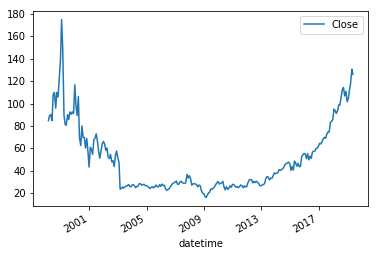

In [4]:
df.plot()

In [5]:
timeseries = df['Close']

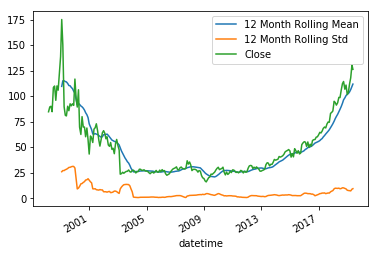

In [6]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.rolling(12).std().plot(label='12 Month Rolling Std')
timeseries.plot()
plt.legend()

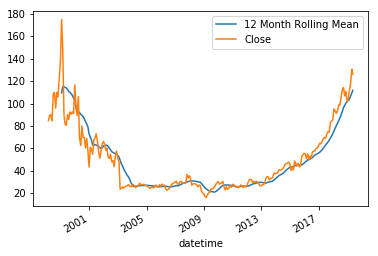

In [7]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.plot()
plt.legend()

## Descomposiciones
## LA DESCOMPOSICION ETS nos permite ver las partes 

<Figure size 432x288 with 0 Axes>

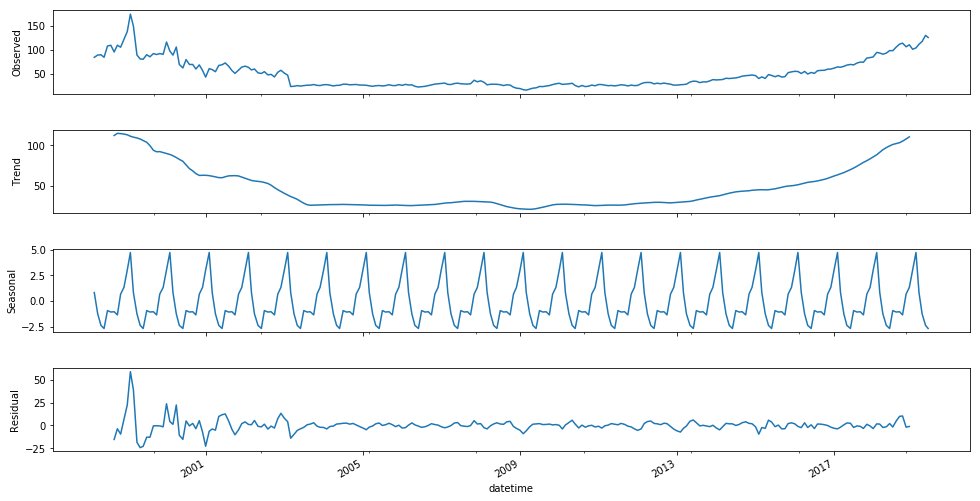

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Close'], freq=12)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

# TESTING PARA Stationarity

In [9]:
df.head()

,Close
datetime,
1998-02-27,84.75
1998-03-31,89.50
1998-04-30,90.12
1998-05-29,84.81
1998-06-30,108.37


In [10]:
from statsmodels.tsa.stattools import adfuller

In [11]:
result = adfuller(df['Close'])

In [12]:
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used']

for value, label in zip(result,labels):
    print(label+' : '+str(value))
    
if result[1] <= 0.05:
    print("Los datos no tienen raíz unitaria y son estacionarios.")
else:
    print("evidencia débil contra hipótesis nula, las series de tiempo tienen una raíz unitaria, lo que indica que no es estacionaria")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -0.2457151884153019
p-value : 0.9328485598792859
#lags Used : 14
Number of Observations Used : 241
evidencia débil contra hipótesis nula, las series de tiempo tienen una raíz unitaria, lo que indica que no es estacionaria


In [13]:
# Store in a function for later use:

def adf_check(time_series):
    """
        Pasar en una serie de tiempo, regresar reporteADF
    """
    
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test')
    labels = ['ADF Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used']
    
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
        
    if result[1] <= 0.05:
        print("evidencia fuerte contra la hipótesis nula, rechazar hipótesis nula. Los datos no tienen una raíz unitaria, lo que indica que es estacionaria")
    else:
        print("evidencia débil contra hipótesis nula, las series de tiempo tienen una raíz unitaria, lo que indica que no es estacionaria")

In [14]:
df['Close First Difference'] = df['Close'] - df['Close'].shift(1)

In [15]:
adf_check(df['Close First Difference'].dropna())

Augmented Dickey-Fuller Test
ADF Test Statistic : -2.5649509676506
p-value : 0.1004596915771771
# Lags Used : 13
Number of Observations Used : 241
evidencia débil contra hipótesis nula, las series de tiempo tienen una raíz unitaria, lo que indica que no es estacionaria


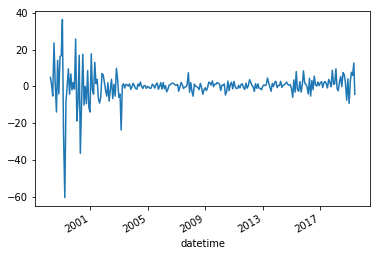

In [16]:
df['Close First Difference'].plot()

In [17]:
# Sometimes it would be necessary to do a second difference
# This is just for show, we didn't need to do a second difference in our case
df['Close Second Difference'] = df['Close First Difference'] - df['Close First Difference'].shift(1)

In [18]:
adf_check(df['Close Second Difference'].dropna())

Augmented Dickey-Fuller Test
ADF Test Statistic : -9.533473919074702
p-value : 2.8495316360576107e-16
# Lags Used : 16
Number of Observations Used : 237
evidencia fuerte contra la hipótesis nula, rechazar hipótesis nula. Los datos no tienen una raíz unitaria, lo que indica que es estacionaria


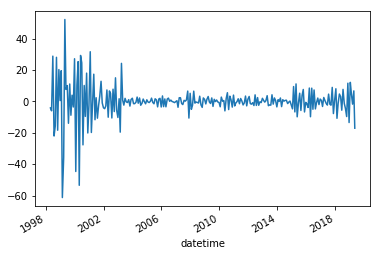

In [19]:
df['Close Second Difference'].plot()

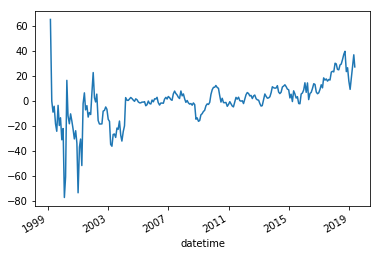

In [20]:
df['Seasonal Difference'] = df['Close'] - df['Close'].shift(12)
df['Seasonal Difference'].plot()

In [21]:
adf_check(df['Seasonal Difference'].dropna())

Augmented Dickey-Fuller Test
ADF Test Statistic : -1.9397562813848908
p-value : 0.3135957103589607
# Lags Used : 13
Number of Observations Used : 230
evidencia débil contra hipótesis nula, las series de tiempo tienen una raíz unitaria, lo que indica que no es estacionaria


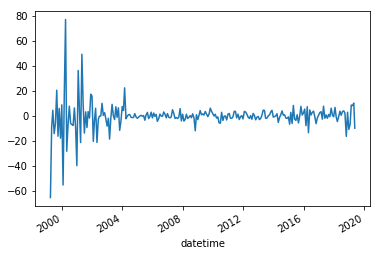

In [22]:
df["Seasonal First Difference"] = df["Close First Difference"] - df["Close First Difference"].shift(12)
df["Seasonal First Difference"].plot()

In [23]:
adf_check(df['Seasonal First Difference'].dropna())

Augmented Dickey-Fuller Test
ADF Test Statistic : -5.770563692534313
p-value : 5.404669060915912e-07
# Lags Used : 15
Number of Observations Used : 227
evidencia fuerte contra la hipótesis nula, rechazar hipótesis nula. Los datos no tienen una raíz unitaria, lo que indica que es estacionaria


## ARIMA

In [26]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [27]:
# tenemos los datos estacionarios:
model = sm.tsa.statespace.SARIMAX(df['Close'], order=(0,1,0), seasonal_order=(1,1,1,12))
results = model.fit()
print(results.summary())

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              Close   No. Observations:                  256
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -839.200
Date:                            Sun, 26 May 2019   AIC                           1684.400
Time:                                    22:31:37   BIC                           1694.879
Sample:                                         0   HQIC                          1688.621
                                            - 256                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.4043      0.034    -12.013      0.000      -0.470      -0.338
ma.S.L12      -0.6734      0.082   

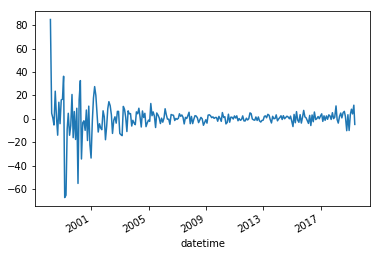

In [28]:
results.resid.plot()

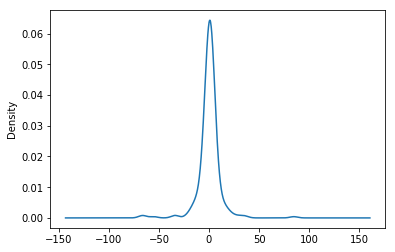

In [29]:
results.resid.plot(kind='kde')

In [30]:
len(df)

256

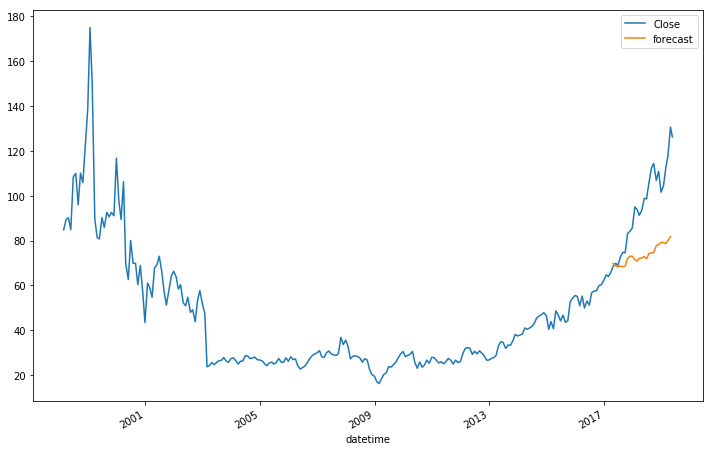

In [31]:
df['forecast'] = results.predict(start= 230, end = 254 , dynamic= True)
df[['Close', 'forecast']].plot(figsize=(12, 8))

In [32]:
len(df)

256

In [33]:
df.tail()

,Close,Close First Difference,Close Second Difference,Seasonal Difference,Seasonal First Difference,forecast
datetime,,,,,,
2019-01-31,104.43,2.86,12.18,9.42,-6.61,79.180562
2019-02-28,112.03,7.60,4.74,18.26,8.84,78.548002
2019-03-29,117.94,5.91,-1.69,26.67,8.41,80.008791
2019-04-30,130.60,12.66,6.75,37.08,10.41,81.690992
2019-05-24,126.24,-4.36,-17.02,27.40,-9.68,NaN


## Datos Futuros

In [34]:
from pandas.tseries.offsets import DateOffset

In [35]:
future_dates = [df.index[-1] + DateOffset(months = x) for x in range(0,12)]

In [36]:
future_dates

[Timestamp('2019-05-24 00:00:00'),
 Timestamp('2019-06-24 00:00:00'),
 Timestamp('2019-07-24 00:00:00'),
 Timestamp('2019-08-24 00:00:00'),
 Timestamp('2019-09-24 00:00:00'),
 Timestamp('2019-10-24 00:00:00'),
 Timestamp('2019-11-24 00:00:00'),
 Timestamp('2019-12-24 00:00:00'),
 Timestamp('2020-01-24 00:00:00'),
 Timestamp('2020-02-24 00:00:00'),
 Timestamp('2020-03-24 00:00:00'),
 Timestamp('2020-04-24 00:00:00')]

In [37]:
future_dates_df = pd.DataFrame(index=future_dates[1:], columns=df.columns)

In [38]:
future_df = pd.concat([df, future_dates_df])

In [39]:
future_df


,Close,Close First Difference,Close Second Difference,Seasonal Difference,Seasonal First Difference,forecast
1998-02-27,84.75,NaN,NaN,NaN,NaN,NaN
1998-03-31,89.50,4.75,NaN,NaN,NaN,NaN
1998-04-30,90.12,0.62,-4.13,NaN,NaN,NaN
1998-05-29,84.81,-5.31,-5.93,NaN,NaN,NaN
1998-06-30,108.37,23.56,28.87,NaN,NaN,NaN
1998-07-31,109.94,1.57,-21.99,NaN,NaN,NaN
1998-08-31,95.94,-14.00,-15.57,NaN,NaN,NaN
1998-09-30,110.06,14.12,28.12,NaN,NaN,NaN
1998-10-30,105.87,-4.19,-18.31,NaN,NaN,NaN
1998-11-30,122.00,16.13,20.32,NaN,NaN,NaN


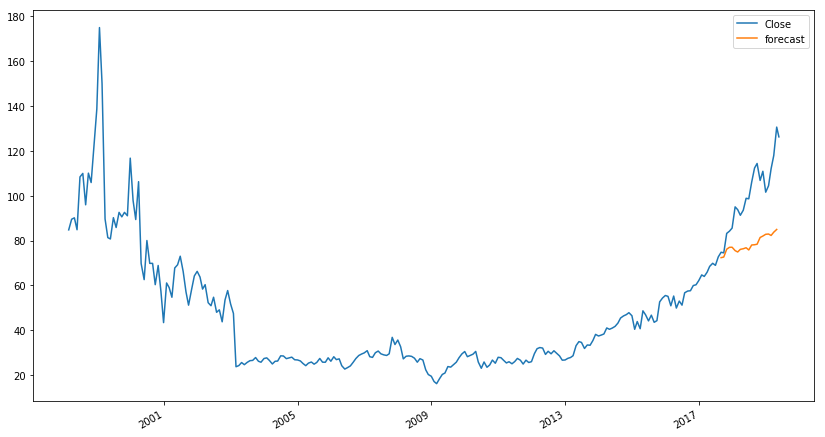

In [40]:
future_df['forecast'] = results.predict(start = 234, end= 254, dynamic = True)
future_df[['Close', 'forecast']].plot(figsize=(14,8))
#future_df['forecast']

In [41]:
future_df.tail()

,Close,Close First Difference,Close Second Difference,Seasonal Difference,Seasonal First Difference,forecast
2019-12-24,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-24,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-24,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-24,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
future_df

,Close,Close First Difference,Close Second Difference,Seasonal Difference,Seasonal First Difference,forecast
1998-02-27,84.75,NaN,NaN,NaN,NaN,NaN
1998-03-31,89.50,4.75,NaN,NaN,NaN,NaN
1998-04-30,90.12,0.62,-4.13,NaN,NaN,NaN
1998-05-29,84.81,-5.31,-5.93,NaN,NaN,NaN
1998-06-30,108.37,23.56,28.87,NaN,NaN,NaN
1998-07-31,109.94,1.57,-21.99,NaN,NaN,NaN
1998-08-31,95.94,-14.00,-15.57,NaN,NaN,NaN
1998-09-30,110.06,14.12,28.12,NaN,NaN,NaN
1998-10-30,105.87,-4.19,-18.31,NaN,NaN,NaN
1998-11-30,122.00,16.13,20.32,NaN,NaN,NaN
